## Computing PAC bases

This is an example of how pac_basis.py module works.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math, Latex
import os

from fca.context import Context
# Local changes:
#   Added __hash__ method to fca.implication.Implication.
#   Changed ___repr__ and __cmp__ methods.
from fca.implication import Implication
from fca.algorithms import compute_dg_basis
import concepts

from pac_basis import *

In [2]:
def context_dataframe(formal_context):
    return pd.DataFrame(
                np.array(formal_context._table).astype(int), 
                columns=formal_context.attributes, 
                index=formal_context.objects)

def display_context(formal_context):
    display(context_dataframe(formal_context))
    
def visualize_lattice(formal_context):
    string_objects = np.array(formal_context.objects, 
                              dtype='str')
    string_attributes = np.array(formal_context.attributes, 
                                 dtype='str')
    display(concepts.Context(string_objects, 
                     string_attributes, 
                     formal_context._table).lattice.graphviz())

def print_implications(implications, sort=True, enumerated=True):
    latex_formula = "";
    if sort:
        implications = sorted(implications)
    for index, implication in enumerate(implications):
        premise = ',~'.join(sorted(implication.premise))
        conclusion = ',~'.join(sorted(implication.conclusion - implication.premise))
        if not implication.premise:
            premise = "\emptyset"
        formula = '$$'
        if enumerated:
            formula += str(index + 1) + '.~~'
        formula += '\{' + premise + '\} \Rightarrow \{' + conclusion + '\}$$'
        latex_formula += formula
        
    display(Latex(latex_formula))
    # print(latex_formula)
    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.rc('font', size=12)

In [3]:
def run_tests(dataset_dir, max_iterations=1000, 
              epsilon=0.1, delta=0.01, mode='pow2', degree=1, verbose=False):
    filenames = os.listdir(dataset_dir)[1:]
    for index, dataset_filename in enumerate(filenames):
        binary_relation_path = os.path.join('data/simple', dataset_filename)
        with np.load(binary_relation_path) as f:
            binary_relation = f['arr_0']
        objects = range(1, binary_relation.shape[0] + 1)
        attributes = [chr(ord('a') + i) for 
                      i in xrange(binary_relation.shape[1])]
        formal_context = Context(binary_relation, 
                                 objects, 
                                 attributes)
        
        implication_expert = ImplicationExpert(formal_context)
        membership_equivalence_expert = MembershipEquivalenceExpert(
            attributes, implication_expert, mode=mode, degree=degree)
        learner = Learner(attributes, membership_equivalence_expert, 
                          epsilon=epsilon, delta=delta)
        error = learner.learn(max_iterations=max_iterations, verbose=False)
        if verbose:
            print('DATASET %d/%d:' % (index + 1, len(filenames)), 
                  dataset_filename)
            print('Context size:', formal_context._table.shape)
            display(context_dataframe(formal_context))
            print('PAC-basis:')
            if not error:
                print_implications(learner.get_basis())
            else:
                print('Number of iterations is excceeded.')
            print('Duquenne-Guigues basis:')
            print_implications(compute_dg_basis(formal_context))
        assert error == 0
        equivalence_conunterexample = membership_equivalence_expert.is_equivalent(
            learner.get_basis())
        if verbose:
            if equivalence_conunterexample is None:
                print('Equivalent')
            else:
                print('Not equivalent, counterexample: ', list(equivalence_conunterexample))
                print('Horn-distance:', 
                      horn_distance(learner.get_basis(), formal_context))
            for stats in learner.get_statistics().iteritems():
                print('Number of %s: %d' % (stats[0], stats[1]))

        print('=' * 100)

## Test the algorithm

In [4]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.1, delta=0.1,
          mode='pow2', verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 7
Number of is_member queries: 134
Number of implication queries: 258
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['j', 'g']
Horn-distance: 0.0087890625
Number of running time: 0
Number of is_approximately_equivalent queries: 31
Number of is_member queries: 1303
Number of implication queries: 2584
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 26
Number of is_member queries: 665
Number of implication queries: 1837
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 7
Number of is_member queries: 129
Number of implication queries: 313
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['b']
Horn-distance: 0.00370788574219
Number of running time: 0
Number of is_approximately_equivalent queries: 29
Number of is_member queries: 1036
Number of implication queries: 2538
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 32
Number of is_member queries: 1558
Number of implication queries: 2314
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a', 'g']
Horn-distance: 0.01318359375
Number of running time: 0
Number of is_approximately_equivalent queries: 26
Number of is_member queries: 915
Number of implication queries: 1423
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['n']
Horn-distance: 0.007080078125
Number of running time: 0
Number of is_approximately_equivalent queries: 28
Number of is_member queries: 1176
Number of implication queries: 2721
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 20
Number of is_member queries: 449
Number of implication queries: 1099
CPU times: user 2.81 s, sys: 350 ms, total: 3.16 s
Wall time: 3.16 s


In [5]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.05, delta=0.1,
          mode='telescoping', degree=0.5, verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 9
Number of is_member queries: 208
Number of implication queries: 398
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['d', 'f']
Horn-distance: 0.0068359375
Number of running time: 0
Number of is_approximately_equivalent queries: 36
Number of is_member queries: 1047
Number of implication queries: 2155
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a', 'c', 'd', 'g', 'f']
Horn-distance: 0.015625
Number of running time: 0
Number of is_approximately_equivalent queries: 22
Number of is_member queries: 361
Number of implication queries: 976
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 7
Number of is_member queries: 200
Number of implication queries: 459
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a']
Horn-distance: 0.0102996826172
Number of running time: 0
Number of is_approximately_equivalent queries: 28
Number of is_member queries: 803
Number of implication queries: 2137
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 38
Number of is_member queries: 972
Number of implication queries: 1694
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a']
Horn-distance: 0.00732421875
Number of running time: 0
Number of is_approximately_equivalent queries: 4
Number of is_member queries: 110
Number of implication queries: 118
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['b']
Horn-distance: 0.0122680664062
Number of running time: 0
Number of is_approximately_equivalent queries: 21
Number of is_member queries: 541
Number of implication queries: 1526
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 17
Number of is_member queries: 325
Number of implication queries: 795
CPU times: user 2.38 s, sys: 354 ms, total: 2.73 s
Wall time: 2.65 s


In [25]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.05, delta=0.1,
          mode='telescoping', degree=0.5, verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

$$a, b, c \Rightarrow d$$$$b \Rightarrow c$$$$c, d \Rightarrow b$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, b, c \Rightarrow d$$$$b \Rightarrow c$$$$c, d \Rightarrow b$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 8
Number of is_member queries: 167
Number of implication queries: 323
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

$$a \Rightarrow d, f$$$$b, d \Rightarrow e$$$$b, f \Rightarrow a, c, d, e, g, h, i, j$$$$c \Rightarrow a, b, d, e, f, g, h, i, j$$$$d, f \Rightarrow a$$$$e \Rightarrow b, d$$$$g \Rightarrow j$$$$h \Rightarrow i$$$$g, h, i, j \Rightarrow a, b, c, d, e, f$$$$i \Rightarrow h$$$$j \Rightarrow g$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, b, c, d, e, f \Rightarrow g, h, i, j$$$$a \Rightarrow d, f$$$$b, d \Rightarrow e$$$$b, f \Rightarrow c$$$$c \Rightarrow b, f$$$$d, f \Rightarrow a$$$$e \Rightarrow b, d$$$$g \Rightarrow j$$$$h \Rightarrow i$$$$g, h, i, j \Rightarrow a, b, c, d, e, f$$$$i \Rightarrow h$$$$j \Rightarrow g$$
Not equivalent, counterexample:  ['c', 'b', 'f']
Horn-distance: 0.0029296875
Number of running time: 0
Number of is_approximately_equivalent queries: 36
Number of is_member queries: 1237
Number of implication queries: 2559
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

$$a, c, d, f, g \Rightarrow e$$$$a, c, e \Rightarrow f$$$$c, e, g \Rightarrow d$$$$c, f \Rightarrow a$$$$d \Rightarrow g$$$$e \Rightarrow c$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, c, d, f, g \Rightarrow e$$$$a, c, e \Rightarrow f$$$$c, e, g \Rightarrow d$$$$c, f \Rightarrow a$$$$d \Rightarrow g$$$$e \Rightarrow c$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 31
Number of is_member queries: 751
Number of implication queries: 2035
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

$$a, b \Rightarrow c, d, e, f$$$$c, d \Rightarrow a, b, e, f$$$$e, f \Rightarrow a, b, c, d$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, b \Rightarrow c, d, e, f$$$$c, d \Rightarrow a, b, e, f$$$$e, f \Rightarrow a, b, c, d$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 8
Number of is_member queries: 165
Number of implication queries: 394
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

$$a \Rightarrow b, c, d, e, f, g, h, i, j, k, l, m, n, o, p$$$$b, g, j, o \Rightarrow a, c, d, e, f, h, i, k, l, m, n, p$$$$c \Rightarrow a, b, d, e, f, g, h, i, j, k, l, m, n, o, p$$$$d \Rightarrow a, b, c, e, f, g, h, i, j, k, l, m, n, o, p$$$$f \Rightarrow a, b, c, d, e, g, h, i, j, k, l, m, n, o, p$$$$h \Rightarrow a, b, c, d, e, f, g, i, j, k, l, m, n, o, p$$$$i \Rightarrow a, b, c, d, e, f, g, h, j, k, l, m, n, o, p$$$$l \Rightarrow a, b, c, d, e, f, g, h, i, j, k, m, n, o, p$$$$m \Rightarrow a, b, c, d, e, f, g, h, i, j, k, l, n, o, p$$$$n \Rightarrow a, b, c, d, e, f, g, h, i, j, k, l, m, o, p$$$$p \Rightarrow a, b, c, d, e, f, g, h, i, j, k, l, m, n, o$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a \Rightarrow b, c, d, e, f, g, h, i, j, k, l, m, n, o, p$$$$b \Rightarrow e, g, i, j, m$$$$b, c, d, e, f, g, h, i, j, k, l, m, n \Rightarrow a, o, p$$$$c \Rightarrow e, g, j, l, m, n$$$$d \Rightarrow i, j, k, n$$$$f \Rightarrow d, h, i, j, k, n$$$$h \Rightarrow d, f, i, j, k, n$$$$g, i, j \Rightarrow b, e, m$$$$i, j, n \Rightarrow d, k$$$$i \Rightarrow j$$$$e, j, n \Rightarrow c, g, l, m$$$$k \Rightarrow d, i, j, n$$$$l \Rightarrow e, g, m$$$$m \Rightarrow e, g$$$$n \Rightarrow j$$$$o \Rightarrow d, f, h, i, j, k, n$$$$p \Rightarrow a, b, c, d, e, f, g, h, i, j, k, l, m, n, o$$
Not equivalent, counterexample:  ['b']
Horn-distance: 0.00102233886719
Number of running time: 0
Number of is_approximately_equivalent queries: 35
Number of is_member queries: 1250
Number of implication queries: 3571
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

$$a, b, d \Rightarrow c, f$$$$a, b, c, d, e, f \Rightarrow g, h, i$$$$a, c, g \Rightarrow h$$$$a, e \Rightarrow c, d$$$$a, f \Rightarrow d$$$$a, c, d, g, h \Rightarrow b, e, f, i$$$$a, h \Rightarrow c, g$$$$a, i \Rightarrow c, g, h$$$$\emptyset \Rightarrow a$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, b, d \Rightarrow f$$$$a, b, c, g, h, i \Rightarrow d, e, f$$$$a, c, d, e, f \Rightarrow b, g, h, i$$$$a, c, g \Rightarrow h$$$$a, d, g \Rightarrow b, c, e, f, h, i$$$$a, e \Rightarrow c, d$$$$a, f \Rightarrow d$$$$a, h \Rightarrow g$$$$a, i \Rightarrow c, g, h$$$$\emptyset \Rightarrow a$$
Not equivalent, counterexample:  ['a', 'd', 'g']
Horn-distance: 0.013671875
Number of running time: 0
Number of is_approximately_equivalent queries: 31
Number of is_member queries: 817
Number of implication queries: 1339
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

$$a, g \Rightarrow b, c, d, e, f, h, i, j, k$$$$\emptyset \Rightarrow a, b, c, d, e, f, g, h, i, j, k$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, b, d, f, g, h, i \Rightarrow k$$$$a, b, f \Rightarrow d, g$$$$a, b, c, d, e \Rightarrow f, g, h, i, j, k$$$$a, c \Rightarrow e$$$$a, d \Rightarrow b$$$$a, e, f \Rightarrow b, c, d, g, h, i, j, k$$$$a, g \Rightarrow b, d, f$$$$a, b, d, e, h \Rightarrow i, j$$$$a, h \Rightarrow b, d$$$$a, i \Rightarrow b, d, h$$$$a, j \Rightarrow b, d, e, h, i$$$$a, k \Rightarrow b, d, f, g, h, i$$$$\emptyset \Rightarrow a$$
Not equivalent, counterexample:  ['a']
Horn-distance: 0.00732421875
Number of running time: 0
Number of is_approximately_equivalent queries: 7
Number of is_member queries: 136
Number of implication queries: 165
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

$$a \Rightarrow b, c, d, e, f, g, h, i, j, k, l, m, n$$$$b \Rightarrow c, e, f, h$$$$c \Rightarrow b, e, f, h$$$$d \Rightarrow a, b, c, e, f, g, h, i, j, k, l, m, n$$$$e, l \Rightarrow a, b, c, d, f, g, h, i, j, k, m, n$$$$e, f, i, k \Rightarrow a, b, c, d, g, h, j, l, m, n$$$$j \Rightarrow a, b, c, d, e, f, g, h, i, k, l, m, n$$$$m \Rightarrow a, b, c, d, e, f, g, h, i, j, k, l, n$$$$n \Rightarrow a, b, c, d, e, f, g, h, i, j, k, l, m$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, b, c, d, e, f, g, h, i \Rightarrow j, k, l, m, n$$$$a \Rightarrow c, e, f, h$$$$b \Rightarrow c, e, f, h$$$$b, c, d, e, f, h \Rightarrow i$$$$c \Rightarrow e$$$$d \Rightarrow c, e$$$$e, f \Rightarrow h$$$$e, l \Rightarrow a, b, c, d, f, g, h, i, j, k, m, n$$$$g, i, j, k, l, m, n \Rightarrow f$$$$c, e, h \Rightarrow f$$$$f, g, h \Rightarrow e$$$$h, k \Rightarrow g, j, l$$$$e, i \Rightarrow h$$$$e, f, h, i \Rightarrow b, c, d$$$$g, i, j, l \Rightarrow m, n$$$$j \Rightarrow l$$$$e, k \Rightarrow a, b, c, d, f, g, h, i, j, l, m, n$$$$f, k \Rightarrow g, i, j, l, m, n$$$$g, k \Rightarrow j, l$$$$k, l \Rightarrow g, j$$$$f, l \Rightarrow g, i, j, k, m, n$$$$m \Rightarrow i, j, l, n$$$$n \Rightarrow i, j, l, m$$
Not equivalent, counterexample:  ['c', 'e']
Horn-distance: 0.0057373046875
Number of running time: 0
Number of is_approximately_equivalent queries: 28
Number of is_member queries: 828
Number of implication queries: 2055
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

$$a, b, d \Rightarrow c, e, f, g, h$$$$a \Rightarrow d$$$$b, c, d \Rightarrow a, e, f, g, h$$$$c \Rightarrow b$$$$e, f \Rightarrow a, b, c, d, g, h$$$$g, h \Rightarrow a, b, c, d, e, f$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$a, b, d \Rightarrow c, e, f, g, h$$$$a \Rightarrow d$$$$b, c, d \Rightarrow a, e, f, g, h$$$$c \Rightarrow b$$$$e, f \Rightarrow a, b, c, d, g, h$$$$g, h \Rightarrow a, b, c, d, e, f$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 25
Number of is_member queries: 454
Number of implication queries: 1105
CPU times: user 1.98 s, sys: 490 ms, total: 2.47 s
Wall time: 2.18 s


In [37]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.05, delta=0.1,
          mode='telescoping', degree=0.5, verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~c\} \Rightarrow \{d\}$$$$2.~~\{b\} \Rightarrow \{c\}$$$$3.~~\{c,~d\} \Rightarrow \{b\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~c\} \Rightarrow \{d\}$$$$2.~~\{b\} \Rightarrow \{c\}$$$$3.~~\{c,~d\} \Rightarrow \{b\}$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 9
Number of is_member queries: 213
Number of implication queries: 392
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a\} \Rightarrow \{b,~c,~d,~e,~f,~g,~h,~i,~j\}$$$$2.~~\{c\} \Rightarrow \{a,~b,~d,~e,~f,~g,~h,~i,~j\}$$$$3.~~\{e\} \Rightarrow \{a,~b,~c,~d,~f,~g,~h,~i,~j\}$$$$4.~~\{g\} \Rightarrow \{a,~b,~c,~d,~e,~f,~h,~i,~j\}$$$$5.~~\{b,~h\} \Rightarrow \{a,~c,~d,~e,~f,~g,~i,~j\}$$$$6.~~\{i\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~h,~j\}$$$$7.~~\{j\} \Rightarrow \{g\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~c,~d,~e,~f\} \Rightarrow \{g,~h,~i,~j\}$$$$2.~~\{a\} \Rightarrow \{d,~f\}$$$$3.~~\{b,~d\} \Rightarrow \{e\}$$$$4.~~\{b,~f\} \Rightarrow \{c\}$$$$5.~~\{c\} \Rightarrow \{b,~f\}$$$$6.~~\{d,~f\} \Rightarrow \{a\}$$$$7.~~\{e\} \Rightarrow \{b,~d\}$$$$8.~~\{g\} \Rightarrow \{j\}$$$$9.~~\{h\} \Rightarrow \{i\}$$$$10.~~\{g,~h,~i,~j\} \Rightarrow \{a,~b,~c,~d,~e,~f\}$$$$11.~~\{i\} \Rightarrow \{h\}$$$$12.~~\{j\} \Rightarrow \{g\}$$
Not equivalent, counterexample:  ['h']
Horn-distance: 0.0244140625
Number of running time: 0
Number of is_approximately_equivalent queries: 18
Number of is_member queries: 350
Number of implication queries: 885
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~c,~d,~f,~g\} \Rightarrow \{e\}$$$$2.~~\{a,~c,~e\} \Rightarrow \{f\}$$$$3.~~\{c,~e,~g\} \Rightarrow \{d\}$$$$4.~~\{c,~f\} \Rightarrow \{a\}$$$$5.~~\{d\} \Rightarrow \{g\}$$$$6.~~\{e\} \Rightarrow \{c\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~c,~d,~f,~g\} \Rightarrow \{e\}$$$$2.~~\{a,~c,~e\} \Rightarrow \{f\}$$$$3.~~\{c,~e,~g\} \Rightarrow \{d\}$$$$4.~~\{c,~f\} \Rightarrow \{a\}$$$$5.~~\{d\} \Rightarrow \{g\}$$$$6.~~\{e\} \Rightarrow \{c\}$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 23
Number of is_member queries: 385
Number of implication queries: 1162
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b\} \Rightarrow \{c,~d,~e,~f\}$$$$2.~~\{c,~d\} \Rightarrow \{a,~b,~e,~f\}$$$$3.~~\{e,~f\} \Rightarrow \{a,~b,~c,~d\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b\} \Rightarrow \{c,~d,~e,~f\}$$$$2.~~\{c,~d\} \Rightarrow \{a,~b,~e,~f\}$$$$3.~~\{e,~f\} \Rightarrow \{a,~b,~c,~d\}$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 8
Number of is_member queries: 154
Number of implication queries: 377
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a\} \Rightarrow \{b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n,~o,~p\}$$$$2.~~\{c\} \Rightarrow \{a,~b,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n,~o,~p\}$$$$3.~~\{d\} \Rightarrow \{a,~b,~c,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n,~o,~p\}$$$$4.~~\{h\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~i,~j,~k,~l,~m,~n,~o,~p\}$$$$5.~~\{l\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~m,~n,~o,~p\}$$$$6.~~\{o\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n,~p\}$$$$7.~~\{p\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n,~o\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a\} \Rightarrow \{b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n,~o,~p\}$$$$2.~~\{b\} \Rightarrow \{e,~g,~i,~j,~m\}$$$$3.~~\{b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n\} \Rightarrow \{a,~o,~p\}$$$$4.~~\{c\} \Rightarrow \{e,~g,~j,~l,~m,~n\}$$$$5.~~\{d\} \Rightarrow \{i,~j,~k,~n\}$$$$6.~~\{f\} \Rightarrow \{d,~h,~i,~j,~k,~n\}$$$$7.~~\{h\} \Rightarrow \{d,~f,~i,~j,~k,~n\}$$$$8.~~\{g,~i,~j\} \Rightarrow \{b,~e,~m\}$$$$9.~~\{i,~j,~n\} \Rightarrow \{d,~k\}$$$$10.~~\{i\} \Rightarrow \{j\}$$$$11.~~\{e,~j,~n\} \Rightarrow \{c,~g,~l,~m\}$$$$12.~~\{k\} \Rightarrow \{d,~i,~j,~n\}$$$$13.~~\{l\} \Rightarrow \{e,~g,~m\}$$$$14.~~\{m\} \Rightarrow \{e,~g\}$$$$15.~~\{n\} \Rightarrow \{j\}$$$$16.~~\{o\} \Rightarrow \{d,~f,~h,~i,~j,~k,~n\}$$$$17.~~\{p\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n,~o\}$$
Not equivalent, counterexample:  ['b']
Horn-distance: 0.00770568847656
Number of running time: 0
Number of is_approximately_equivalent queries: 24
Number of is_member queries: 597
Number of implicatio

,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~d\} \Rightarrow \{f\}$$$$2.~~\{a,~d,~g\} \Rightarrow \{b,~c,~e,~f,~h,~i\}$$$$3.~~\{a,~e\} \Rightarrow \{b,~c,~d,~f,~g,~h,~i\}$$$$4.~~\{a,~f\} \Rightarrow \{d\}$$$$5.~~\{a,~h\} \Rightarrow \{g\}$$$$6.~~\{a,~i\} \Rightarrow \{b,~c,~d,~e,~f,~g,~h\}$$$$7.~~\{\emptyset\} \Rightarrow \{a\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~d\} \Rightarrow \{f\}$$$$2.~~\{a,~b,~c,~g,~h,~i\} \Rightarrow \{d,~e,~f\}$$$$3.~~\{a,~c,~d,~e,~f\} \Rightarrow \{b,~g,~h,~i\}$$$$4.~~\{a,~c,~g\} \Rightarrow \{h\}$$$$5.~~\{a,~d,~g\} \Rightarrow \{b,~c,~e,~f,~h,~i\}$$$$6.~~\{a,~e\} \Rightarrow \{c,~d\}$$$$7.~~\{a,~f\} \Rightarrow \{d\}$$$$8.~~\{a,~h\} \Rightarrow \{g\}$$$$9.~~\{a,~i\} \Rightarrow \{c,~g,~h\}$$$$10.~~\{\emptyset\} \Rightarrow \{a\}$$
Not equivalent, counterexample:  ['a', 'c', 'g']
Horn-distance: 0.0078125
Number of running time: 0
Number of is_approximately_equivalent queries: 25
Number of is_member queries: 637
Number of implication queries: 951
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~f\} \Rightarrow \{d,~g,~h\}$$$$2.~~\{a,~c,~d,~e\} \Rightarrow \{b,~f,~g,~h,~i,~j,~k\}$$$$3.~~\{a,~c\} \Rightarrow \{e\}$$$$4.~~\{a,~g\} \Rightarrow \{b,~d,~f,~h,~i,~k\}$$$$5.~~\{a,~h\} \Rightarrow \{b,~d,~f,~g,~i,~k\}$$$$6.~~\{a,~i\} \Rightarrow \{b,~d,~f,~g,~h,~k\}$$$$7.~~\{a,~j\} \Rightarrow \{b,~c,~d,~e,~f,~g,~h,~i,~k\}$$$$8.~~\{a,~k\} \Rightarrow \{b,~d,~f,~g,~h,~i\}$$$$9.~~\{\emptyset\} \Rightarrow \{a\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~d,~f,~g,~h,~i\} \Rightarrow \{k\}$$$$2.~~\{a,~b,~f\} \Rightarrow \{d,~g\}$$$$3.~~\{a,~b,~c,~d,~e\} \Rightarrow \{f,~g,~h,~i,~j,~k\}$$$$4.~~\{a,~c\} \Rightarrow \{e\}$$$$5.~~\{a,~d\} \Rightarrow \{b\}$$$$6.~~\{a,~e,~f\} \Rightarrow \{b,~c,~d,~g,~h,~i,~j,~k\}$$$$7.~~\{a,~g\} \Rightarrow \{b,~d,~f\}$$$$8.~~\{a,~b,~d,~e,~h\} \Rightarrow \{i,~j\}$$$$9.~~\{a,~h\} \Rightarrow \{b,~d\}$$$$10.~~\{a,~i\} \Rightarrow \{b,~d,~h\}$$$$11.~~\{a,~j\} \Rightarrow \{b,~d,~e,~h,~i\}$$$$12.~~\{a,~k\} \Rightarrow \{b,~d,~f,~g,~h,~i\}$$$$13.~~\{\emptyset\} \Rightarrow \{a\}$$
Not equivalent, counterexample:  ['a', 'd']
Horn-distance: 0.005859375
Number of running time: 0
Number of is_approximately_equivalent queries: 29
Number of is_member queries: 925
Number of implication queries: 1520
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a\} \Rightarrow \{b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n\}$$$$2.~~\{c\} \Rightarrow \{a,~b,~d,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n\}$$$$3.~~\{d\} \Rightarrow \{a,~b,~c,~e,~f,~g,~h,~i,~j,~k,~l,~m,~n\}$$$$4.~~\{e,~h,~k,~l\} \Rightarrow \{a,~b,~c,~d,~f,~g,~i,~j,~m,~n\}$$$$5.~~\{e,~i\} \Rightarrow \{a,~b,~c,~d,~f,~g,~h,~j,~k,~l,~m,~n\}$$$$6.~~\{j\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~h,~i,~k,~l,~m,~n\}$$$$7.~~\{g,~k\} \Rightarrow \{a,~b,~c,~d,~e,~f,~h,~i,~j,~l,~m,~n\}$$$$8.~~\{f,~l\} \Rightarrow \{a,~b,~c,~d,~e,~g,~h,~i,~j,~k,~m,~n\}$$$$9.~~\{m,~n\} \Rightarrow \{a,~b,~c,~d,~e,~f,~g,~h,~i,~j,~k,~l\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~c,~d,~e,~f,~g,~h,~i\} \Rightarrow \{j,~k,~l,~m,~n\}$$$$2.~~\{a\} \Rightarrow \{c,~e,~f,~h\}$$$$3.~~\{b\} \Rightarrow \{c,~e,~f,~h\}$$$$4.~~\{b,~c,~d,~e,~f,~h\} \Rightarrow \{i\}$$$$5.~~\{c\} \Rightarrow \{e\}$$$$6.~~\{d\} \Rightarrow \{c,~e\}$$$$7.~~\{e,~f\} \Rightarrow \{h\}$$$$8.~~\{e,~l\} \Rightarrow \{a,~b,~c,~d,~f,~g,~h,~i,~j,~k,~m,~n\}$$$$9.~~\{g,~i,~j,~k,~l,~m,~n\} \Rightarrow \{f\}$$$$10.~~\{c,~e,~h\} \Rightarrow \{f\}$$$$11.~~\{f,~g,~h\} \Rightarrow \{e\}$$$$12.~~\{h,~k\} \Rightarrow \{g,~j,~l\}$$$$13.~~\{e,~i\} \Rightarrow \{h\}$$$$14.~~\{e,~f,~h,~i\} \Rightarrow \{b,~c,~d\}$$$$15.~~\{g,~i,~j,~l\} \Rightarrow \{m,~n\}$$$$16.~~\{j\} \Rightarrow \{l\}$$$$17.~~\{e,~k\} \Rightarrow \{a,~b,~c,~d,~f,~g,~h,~i,~j,~l,~m,~n\}$$$$18.~~\{f,~k\} \Rightarrow \{g,~i,~j,~l,~m,~n\}$$$$19.~~\{g,~k\} \Rightarrow \{j,~l\}$$$$20.~~\{k,~l\} \Rightarrow \{g,~j\}$$$$21.~~\{f,~l\} \Rightarrow \{g,~i,~j,~k,~m,~n\}$$$$22.~~\{m\} \Rightarrow \{i,~j,~l,~n\}$$$$23.~~\{n\} \Rightarrow \{i,~j,

,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~d\} \Rightarrow \{c,~e,~f,~g,~h\}$$$$2.~~\{a\} \Rightarrow \{d\}$$$$3.~~\{b,~c,~d\} \Rightarrow \{a,~e,~f,~g,~h\}$$$$4.~~\{c\} \Rightarrow \{b\}$$$$5.~~\{e,~f\} \Rightarrow \{a,~b,~c,~d,~g,~h\}$$$$6.~~\{g,~h\} \Rightarrow \{a,~b,~c,~d,~e,~f\}$$
Duquenne-Guigues basis:


<IPython.core.display.Latex object>

$$1.~~\{a,~b,~d\} \Rightarrow \{c,~e,~f,~g,~h\}$$$$2.~~\{a\} \Rightarrow \{d\}$$$$3.~~\{b,~c,~d\} \Rightarrow \{a,~e,~f,~g,~h\}$$$$4.~~\{c\} \Rightarrow \{b\}$$$$5.~~\{e,~f\} \Rightarrow \{a,~b,~c,~d,~g,~h\}$$$$6.~~\{g,~h\} \Rightarrow \{a,~b,~c,~d,~e,~f\}$$
Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 21
Number of is_member queries: 386
Number of implication queries: 886
CPU times: user 2.23 s, sys: 679 ms, total: 2.91 s
Wall time: 2.4 s


In [4]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.01, delta=0.001,
          mode='pow2', verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 7
Number of is_member queries: 1440
Number of implication queries: 2713
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 43
Number of is_member queries: 8368
Number of implication queries: 12498
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 25
Number of is_member queries: 3448
Number of implication queries: 9542
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 7
Number of is_member queries: 1424
Number of implication queries: 3182
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['i']
Horn-distance: 0.000259399414062
Number of running time: 2
Number of is_approximately_equivalent queries: 38
Number of is_member queries: 13442
Number of implication queries: 16900
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 32
Number of is_member queries: 5505
Number of implication queries: 7309
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a', 'b', 'd', 'g', 'f', 'i', 'h', 'k']
Horn-distance: 0.00048828125
Number of running time: 0
Number of is_approximately_equivalent queries: 45
Number of is_member queries: 9928
Number of implication queries: 11804
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 10
Number of is_approximately_equivalent queries: 83
Number of is_member queries: 57129
Number of implication queries: 71986
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 24
Number of is_member queries: 3260
Number of implication queries: 6617
CPU times: user 28.5 s, sys: 849 ms, total: 29.3 s
Wall time: 29.3 s


In [6]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.01, delta=0.001,
          mode='telescoping', degree=1, verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1237
Number of is_approxemately_equivalent queries: 9
Number of implication queries: 2328
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 4724
Number of is_approxemately_equivalent queries: 41
Number of implication queries: 7457
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1594
Number of is_approxemately_equivalent queries: 23
Number of implication queries: 4343
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1161
Number of is_approxemately_equivalent queries: 8
Number of implication queries: 2593
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['f']
Horn-distance: 0.000900268554688
Number of is_member queries: 3920
Number of is_approxemately_equivalent queries: 37
Number of implication queries: 6635
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 2546
Number of is_approxemately_equivalent queries: 34
Number of implication queries: 3442
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a', 'c', 'e']
Horn-distance: 0.00390625
Number of is_member queries: 2405
Number of is_approxemately_equivalent queries: 36
Number of implication queries: 3171
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['i', 'h', 'e']
Horn-distance: 0.00079345703125
Number of is_member queries: 19366
Number of is_approxemately_equivalent queries: 66
Number of implication queries: 27221
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1437
Number of is_approxemately_equivalent queries: 17
Number of implication queries: 3107
CPU times: user 18.6 s, sys: 856 ms, total: 19.5 s
Wall time: 19.3 s


In [6]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.01, delta=0.001,
          mode='telescoping', degree=0.7, verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 9
Number of is_member queries: 1183
Number of implication queries: 2259
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 40
Number of is_member queries: 4445
Number of implication queries: 7173
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 22
Number of is_member queries: 1625
Number of implication queries: 4532
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 8
Number of is_member queries: 1131
Number of implication queries: 2561
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['f']
Horn-distance: 0.000473022460938
Number of running time: 2
Number of is_approximately_equivalent queries: 40
Number of is_member queries: 8899
Number of implication queries: 12328
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 31
Number of is_member queries: 4012
Number of implication queries: 5410
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 52
Number of is_member queries: 5308
Number of implication queries: 6832
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['k', 'e']
Horn-distance: 0.00177001953125
Number of running time: 2
Number of is_approximately_equivalent queries: 60
Number of is_member queries: 9808
Number of implication queries: 15103
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of running time: 0
Number of is_approximately_equivalent queries: 18
Number of is_member queries: 1557
Number of implication queries: 3251
CPU times: user 8.63 s, sys: 602 ms, total: 9.23 s
Wall time: 9.48 s


In [8]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.01, delta=0.001,
          mode='telescoping', degree=0.5, verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1149
Number of is_approxemately_equivalent queries: 9
Number of implication queries: 2153
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a', 'd', 'f']
Horn-distance: 0.001953125
Number of is_member queries: 3216
Number of is_approxemately_equivalent queries: 38
Number of implication queries: 5388
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1386
Number of is_approxemately_equivalent queries: 17
Number of implication queries: 3875
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1105
Number of is_approxemately_equivalent queries: 7
Number of implication queries: 2458
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a']
Horn-distance: 0.0006103515625
Number of is_member queries: 7533
Number of is_approxemately_equivalent queries: 42
Number of implication queries: 10873
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 3040
Number of is_approxemately_equivalent queries: 41
Number of implication queries: 4299
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a', 'c', 'b', 'e', 'd']
Horn-distance: 0.0009765625
Number of is_member queries: 7346
Number of is_approxemately_equivalent queries: 46
Number of implication queries: 9025
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['k', 'e']
Horn-distance: 0.00115966796875
Number of is_member queries: 14337
Number of is_approxemately_equivalent queries: 63
Number of implication queries: 20168
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1394
Number of is_approxemately_equivalent queries: 22
Number of implication queries: 3010
CPU times: user 18.8 s, sys: 741 ms, total: 19.5 s
Wall time: 19.4 s


In [32]:
%%time
run_tests('data/simple', max_iterations=200, epsilon=0.01, delta=0.001,
          mode='telescoping', degree=2, verbose=True)

DATASET 1/9: context_1.npz
Context size: (4, 4)


,a,b,c,d
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1316
Number of is_approxemately_equivalent queries: 8
Number of implication queries: 2502
DATASET 2/9: context_2.npz
Context size: (6, 10)


,a,b,c,d,e,f,g,h,i,j
1,1,0,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,0,1,1,0
3,0,1,1,0,0,1,1,0,0,1
4,0,1,1,0,0,1,0,1,1,0
5,0,1,0,1,1,0,1,0,0,1
6,0,1,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 3314
Number of is_approxemately_equivalent queries: 38
Number of implication queries: 5468
DATASET 3/9: digits.npz
Context size: (10, 7)


,a,b,c,d,e,f,g
1,1,0,1,1,1,1,1
2,0,0,0,0,0,1,1
3,1,1,1,0,1,1,0
4,1,1,1,0,0,1,1
5,0,1,0,1,0,1,1
6,1,1,1,1,0,0,1
7,0,1,1,1,1,0,1
8,1,0,0,0,0,1,1
9,1,1,1,1,1,1,1
10,1,1,0,1,0,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1901
Number of is_approxemately_equivalent queries: 26
Number of implication queries: 5183
DATASET 4/9: gewaesser.npz
Context size: (8, 6)


,a,b,c,d,e,f
1,1,0,1,0,1,0
2,1,0,1,0,0,1
3,1,0,0,1,1,0
4,1,0,0,1,0,1
5,0,1,1,0,1,0
6,0,1,1,0,0,1
7,0,1,0,1,1,0
8,0,1,0,1,0,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1289
Number of is_approxemately_equivalent queries: 8
Number of implication queries: 2967
DATASET 5/9: lattice.npz
Context size: (14, 16)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['a']
Horn-distance: 0.00108337402344
Number of is_member queries: 3671
Number of is_approxemately_equivalent queries: 28
Number of implication queries: 5668
DATASET 6/9: liveinwater.npz
Context size: (8, 9)


,a,b,c,d,e,f,g,h,i
1,1,1,0,0,0,0,1,0,0
2,1,1,0,0,0,0,1,1,0
3,1,1,1,0,0,0,1,1,0
4,1,0,1,0,0,0,1,1,1
5,1,1,0,1,0,1,0,0,0
6,1,1,1,1,0,1,0,0,0
7,1,0,1,1,1,0,0,0,0
8,1,0,1,1,0,1,0,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 2914
Number of is_approxemately_equivalent queries: 34
Number of implication queries: 4015
DATASET 7/9: relations.npz
Context size: (10, 11)


,a,b,c,d,e,f,g,h,i,j,k
1,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,0,0,0,0,0,0
6,1,1,0,1,1,0,0,1,1,1,0
7,1,1,0,1,0,1,1,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,0
9,1,1,0,1,0,1,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1,1


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 6169
Number of is_approxemately_equivalent queries: 44
Number of implication queries: 7562
DATASET 8/9: tealady.npz
Context size: (18, 14)


,a,b,c,d,e,f,g,h,i,j,k,l,m,n
1,1,1,1,1,1,1,0,1,1,0,0,0,0,0
2,1,1,1,0,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,0,0,0,0,0
4,1,0,1,1,1,1,1,1,0,0,0,0,0,0
5,0,0,1,1,1,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,1,0,1,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,1,1,1,0,0,0,0,0
10,0,0,0,0,0,0,1,1,1,0,0,1,0,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Not equivalent, counterexample:  ['i', 'h', 'e']
Horn-distance: 0.001220703125
Number of is_member queries: 14391
Number of is_approxemately_equivalent queries: 65
Number of implication queries: 21119
DATASET 9/9: vowels.npz
Context size: (12, 8)


,a,b,c,d,e,f,g,h
1,1,0,0,1,0,1,0,1
2,1,0,0,1,0,1,1,0
3,1,0,0,1,1,0,0,1
4,1,0,0,1,1,0,1,0
5,0,1,0,1,0,1,0,1
6,0,1,0,1,0,1,1,0
7,0,1,0,1,1,0,0,1
8,0,1,0,1,1,0,1,0
9,0,1,1,0,0,1,0,1
10,0,1,1,0,0,1,1,0


PAC-basis:


<IPython.core.display.Latex object>

Duquenne-Guigues basis:


<IPython.core.display.Latex object>

Equivalent
Number of is_member queries: 1795
Number of is_approxemately_equivalent queries: 18
Number of implication queries: 3774
CPU times: user 18.3 s, sys: 830 ms, total: 19.1 s
Wall time: 18.8 s


We can see that, in some cases, PAC-bases found were not equivalent to corresponding actual DG-bases, but the Horn distance between them was always less than $\varepsilon = 0.01$. Let's look closer at one of such cases.

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
4,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0
5,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
6,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0
7,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
8,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0
9,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,1,0,1,0,1,1,1,1,0,0,1,0,0


Duquenne-Guigues basis:


<IPython.core.display.Latex object>

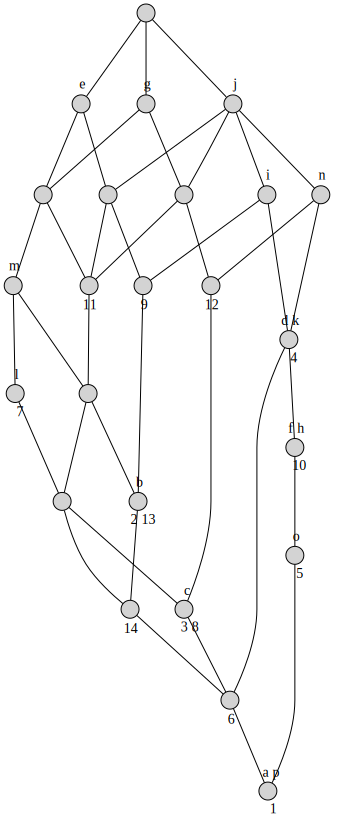

In [7]:
binary_relation_path = os.path.join('data/simple', 'lattice.npz')
with np.load(binary_relation_path) as f:
    binary_relation = f['arr_0']
objects = range(1, binary_relation.shape[0] + 1)
attributes = [chr(ord('a') + i) for 
              i in xrange(binary_relation.shape[1])]
formal_context = Context(binary_relation, 
                         objects, 
                         attributes)
display(context_dataframe(formal_context))
print("Duquenne-Guigues basis:")
print_implications(compute_dg_basis(formal_context))
visualize_lattice(formal_context)

In [8]:
%%time
implication_expert = ImplicationExpert(formal_context)
membership_equivalence_expert = MembershipEquivalenceExpert(attributes, implication_expert)
learner = Learner(attributes, membership_equivalence_expert, epsilon=0.0001, delta=0.1)
error = learner.learn(max_iterations=1000, verbose=True)

1. Hypothetical basis: []
Negative counterexample: ['k', 'j', 'm', 'l', 'o', 'n', 'p']

2. Hypothetical basis: [{k,j,m,l,o,n,p} -> {a,c,b,e,d,g,f,i,h}]
Negative counterexample: ['c', 'b', 'd', 'f', 'h', 'l', 'o', 'p']

3. Hypothetical basis: [{p,l,o} -> {a,c,b,e,d,g,f,i,h,k,j,m,n}]
Negative counterexample: ['a', 'b', 'd', 'm', 'o', 'n']

4. Hypothetical basis: [{o} -> {a,c,b,e,d,g,f,i,h,k,j,m,l,n,p}]
Negative counterexample: ['i', 'h', 'c', 'e', 'p']

5. Hypothetical basis: [{o} -> {a,c,b,e,d,g,f,i,h,k,j,m,l,n,p}, {i,h,c,e,p} -> {a,b,d,g,f,k,j,m,l,o,n}]
Negative counterexample: ['a', 'c', 'e', 'f', 'h', 'k', 'j', 'n']

6. Hypothetical basis: [{o} -> {a,c,b,e,d,g,f,i,h,k,j,m,l,n,p}, {h,c,e} -> {a,b,d,g,f,i,k,j,m,l,o,n,p}]
Negative counterexample: ['c', 'g', 'i', 'k', 'm', 'l', 'p']

7. Hypothetical basis: [{o} -> {a,c,b,e,d,g,f,i,h,k,j,m,l,n,p}, {c} -> {a,b,e,d,g,f,i,h,k,j,m,l,o,n,p}]
Negative counterexample: ['b', 'f', 'i', 'm', 'l', 'n']

8. Hypothetical basis: [{o} -> {a,c,b,e,d,g,f,

In [9]:
print_implications(learner.get_basis())

<IPython.core.display.Latex object>

In [10]:
print_implications(compute_dg_basis(formal_context))

<IPython.core.display.Latex object>

In [11]:
print(membership_equivalence_expert.is_equivalent(learner.get_basis()))

None


Thus, we found correct basis after decreasing $\varepsilon$ from 0.01 to 0.0001.